In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.preprocessing import sequence

from TransformerComplet import *

from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Concatenate, MultiHeadAttention


In [10]:
# Chargement des fichiers CSV
# Chargement des fichiers CSV
benin_data = pd.read_csv("../../data/Bell_DNS Dataset/features_domain_benign_csv.csv")
malware_data = pd.read_csv("../../data/Bell_DNS Dataset/features-domain_Malware.csv")
phishing_data = pd.read_csv("../../data/Bell_DNS Dataset/features-domain_phishing.csv")
spam_data = pd.read_csv("../../data/Bell_DNS Dataset/features-domain_Spam.csv")

# Ajout de la colonne 'Class' 
benin_data['Class'] = 'Benin'
malware_data['Class'] = 'Malware'
phishing_data['Class'] = 'Phishing'
spam_data['Class'] = 'Spam'


In [11]:
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
####################### Features selection ######################


# Concaténation de tous les ensembles de données
all_data = pd.concat([benin_data, malware_data, phishing_data, spam_data], ignore_index=True)

# Spécifier la colonne cible [le faire avant l'encodage ]
y = all_data['Class']

print(all_data.dtypes)

print(all_data.info())

all_data.isnull().sum().sort_values(ascending=False)

X_numerical = all_data.select_dtypes(include=['int64', 'float64'])

X_categorical = all_data.select_dtypes(exclude='number')

print( all_data.shape)
print( X_numerical.shape)
print( X_categorical.shape)

print(all_data['Class'].value_counts())


subdomain                  float64
tld                         object
sld                         object
len                          int64
numeric_percentage         float64
char_distribution           object
entropy                    float64
1gram                       object
2gram                       object
3gram                       object
longest_word                object
distance_from_bad_words     object
typos                       object
obfuscate_at_sign           object
dec_8                        int64
dec_32                       int64
oc_8                         int64
oc_32                        int64
hex_8                        int64
hex_32                       int64
puny_coded                   int64
shortened                   object
Domain_Name                 object
Registrar                   object
Registrant_Name             object
Creation_Date_Time          object
Emails                      object
Domain_Age                  object
Organization        

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# 2. Vérification des colonnes vides
if X_numerical.isnull().any().any():
    # Imputer les valeurs manquantes pour les caractéristiques numériques
    numerical_imputer = SimpleImputer(strategy='mean')
    X_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_numerical), columns=X_numerical.columns)

    #prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()

    # Création d'un scaler
    scaler = MinMaxScaler()

    # Ajustement du scaler aux données
    scaler.fit(X_numerical_imputed)

    # Transformation des fonctionnalités numériques
    scaled_numeric_features = scaler.transform(X_numerical_imputed)


    print(scaled_numeric_features)

    # Apres transformation Création d' un DataFrame à partir des valeurs transformées

    scaled_df = pd.DataFrame(scaled_numeric_features, columns=X_numerical_imputed.columns)

    # Afficher le DataFrame avec les valeurs transformées
    print("Après transformation")
    print(scaled_df)

    total_size = scaled_df.shape
    print("Taille totale des caractéristiques numériques après transformations :", total_size)

    ############# j'affiche la variance ###########
    scaled_df.var()

else:
    print("Pas de valeurs manquantes dans les caractéristiques numériques. Aucune imputation nécessaire.")


[[0.00000000e+00 3.89610390e-02 0.00000000e+00 ... 0.00000000e+00
  1.63603505e-07 0.00000000e+00]
 [0.00000000e+00 3.89610390e-02 0.00000000e+00 ... 0.00000000e+00
  1.63603505e-07 0.00000000e+00]
 [1.00000000e+00 5.84415584e-02 0.00000000e+00 ... 0.00000000e+00
  1.63603505e-07 0.00000000e+00]
 ...
 [0.00000000e+00 7.79220779e-02 1.23188406e-01 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.14285714e-02 6.43939394e-02 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.42857143e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
Après transformation
       subdomain       len  numeric_percentage   entropy  dec_8  dec_32  oc_8   
0            0.0  0.038961            0.000000  0.384930    0.0     0.0   0.0  \
1            0.0  0.038961            0.000000  0.384930    0.0     0.0   0.0   
2            1.0  0.058442            0.000000  0.443538    0.0     0.0   0.0   
3            1.0  0.058442            0.000000  0.44353

In [15]:
##################### Maintenant que faire des attribut categoriciel ??########
#### vue que les Selecteur des meilleurs features utiliser les estimateurs probailistes, les DT,les RF ############

### Pour cela il faut les encoder soit avec le [OneHotEncoder, OrdinalEnocder,Trigonometrie] ########


from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder



# Imputer les valeurs manquantes pour les caractéristiques categoriques
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical), columns=X_categorical.columns)


# Appliquer l'encodage One-Hot aux caractéristiques catégorielles
#encoder = OneHotEncoder()
#X_categorical_encoded = encoder.fit_transform(X_categorical).toarray()


# Convertir les colonnes catégorielles en chaînes de caractères (parceque actuellement sa contient les int et les str il faut normaliser en str)
X_categorical_imputed = X_categorical_imputed.astype(str)

# Utiliser l'encodage ordinal pour transformer les données catégorielles en valeurs numériques
ordinal_encoder = OrdinalEncoder()
X_categorical_encoded = pd.DataFrame(ordinal_encoder.fit_transform(X_categorical_imputed), columns=X_categorical_imputed.columns)


###### une fois fait je concatene avec les donnee numrrique et je passe a mon algorithme de selection des caracteristique 


# Concaténer les caractéristiques numériques et catégorielles
X_combined = pd.concat([X_numerical_imputed, X_categorical_encoded], axis=1)

all_feature = X_combined.shape[1]
print("Nombre total de caractéristiques numeriques et categoriciel:", all_feature)


### on se rassure que tout est bien convertis pour eviter l'erreur plus bas
### car on va supprimer la colonne class car c'es la cible utiliser pour la sectionne des meilleurs features
X_combined.columns = X_combined.columns.astype(str)

Nombre total de caractéristiques numeriques et categoriciel: 36


In [16]:
#La Class ne doit pas faire partir des features important car c'est la cible

# Imprimer les noms des colonnes pour déboguer
print(X_combined.columns)

# Supprimer les colonnes de classe s'il y en a

class_columns_to_drop = ['Class']

existing_class_columns = set(class_columns_to_drop).intersection(X_combined.columns)

if existing_class_columns:
    X_combined = X_combined.drop(existing_class_columns, axis=1)

# Imprimer à nouveau les noms des colonnes pour vérifier
print(X_combined.columns)

Index(['subdomain', 'len', 'numeric_percentage', 'entropy', 'dec_8', 'dec_32',
       'oc_8', 'oc_32', 'hex_8', 'hex_32', 'puny_coded', 'Alexa_Rank',
       'Page_Rank', 'tld', 'sld', 'char_distribution', '1gram', '2gram',
       '3gram', 'longest_word', 'distance_from_bad_words', 'typos',
       'obfuscate_at_sign', 'shortened', 'Domain_Name', 'Registrar',
       'Registrant_Name', 'Creation_Date_Time', 'Emails', 'Domain_Age',
       'Organization', 'State', 'Country', 'Name_Server_Count', 'Class',
       'Unnamed: 34'],
      dtype='object')
Index(['subdomain', 'len', 'numeric_percentage', 'entropy', 'dec_8', 'dec_32',
       'oc_8', 'oc_32', 'hex_8', 'hex_32', 'puny_coded', 'Alexa_Rank',
       'Page_Rank', 'tld', 'sld', 'char_distribution', '1gram', '2gram',
       '3gram', 'longest_word', 'distance_from_bad_words', 'typos',
       'obfuscate_at_sign', 'shortened', 'Domain_Name', 'Registrar',
       'Registrant_Name', 'Creation_Date_Time', 'Emails', 'Domain_Age',
       'Organizati

In [17]:

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import StratifiedKFold #Pour effectuer une validation croisée stratifiée.
from sklearn.feature_selection import RFECV #La classe qui effectue la sélection de caractéristiques

# Modèle pour la sélection de fonctionnalités
estimator = DecisionTreeClassifier()

#je choisi le nombre de parametre
num_features_to_select = 10
# Créer une instance de RFECV
rfe_cv = RFECV(estimator, step=1, cv=StratifiedKFold(10), verbose=1,n_jobs=-1, min_features_to_select=num_features_to_select)

# Ajuster RFECV sur les données
rfe_cv.fit(X_combined, y)

#############################################################################
################################  ne pas executer cette section #############

# Créer une instance de RFECV avec un nombre fixe de caractéristiques à sélectionner (20 dans cet exemple)

#num_features_to_select = 20
#rfe_cv = RFECV(estimator=DecisionTreeClassifier(), step=1, cv=StratifiedKFold(10), verbose=1, n_jobs=-1, min_features_to_select=num_features_to_select)


# Créer une instance de RFECV avec un nombre fixe de caractéristiques à sélectionner (15 dans cet exemple)
#num_features_to_select = 15
#rfe_cv = RFECV(estimator=DecisionTreeClassifier(), step=1, cv=StratifiedKFold(10), verbose=1, n_jobs=-1, n_features_to_select=num_features_to_select)


Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), min_features_to_select=10, n_jobs=-1,
      verbose=1)

In [18]:

import numpy as np

# Afficher les caractéristiques sélectionnées
selected_features = list(X_combined.columns[rfe_cv.support_])
print("Caractéristiques importantes (RFECV):")
print(selected_features)


#j'utilise rfe_cv.support_ pour obtenir le masque booléen des caractéristiques sélectionnées par l'algorithme RFECV. Ensuite, vous utilisez X_combined.columns[rfe_cv.support_] pour sélectionner les colonnes correspondantes et les convertir en une liste de noms de caractéristiques.
# Afficher les caractéristiques sélectionnées avec leurs indices
selected_features_with_indices = list(zip(X_combined.columns[rfe_cv.support_], np.where(rfe_cv.support_)[0]))
print("Caractéristiques importantes (RFECV):")
for name, index in selected_features_with_indices:
    print(f"{name}: {index}")



# Créer un dictionnaire indiquant le type de chaque colonne
column_types = {}
for column in X_numerical_imputed.columns:
    column_types[column] = 'Numerical'

for column in X_categorical_imputed.columns:
    column_types[column] = 'Categorical'

# Afficher les caractéristiques sélectionnées avec leurs indices et types
selected_features_with_indices_and_types = [(name, index, column_types[name]) for name, index in selected_features_with_indices]

print("Caractéristiques importantes (RFECV):")
for name, index, feature_type in selected_features_with_indices_and_types:
    print(f"{name} (Index {index}): {feature_type}")



#### AFFICHAGE 2 ####################
selected_columns_indices = rfe_cv.get_support(indices=True)
# Obtenir les noms des colonnes sélectionnées
selected_columns_names = X_combined.columns[selected_columns_indices]

# Afficher les caractéristiques sélectionnées avec leurs noms
selected_features_with_names = list(zip(selected_columns_indices, selected_columns_names))
print("Caractéristiques importantes (RFECV):")
print(selected_features_with_names)


########### AFFICHAGE 3 ###########

# Afficher les caractéristiques sélectionnées avec leurs noms et types
selected_features_with_names_and_types = []

for index, name in selected_features_with_names:
    # Obtenir le type de la caractéristique
    feature_type = "Categorical" if name in X_categorical_imputed else "Numerical"
    
    # Ajouter à la liste
    selected_features_with_names_and_types.append((name, feature_type))

print("Caractéristiques importantes (RFECV):")
for name, feature_type in selected_features_with_names_and_types:
    print(f"{name}: {feature_type}")

Caractéristiques importantes (RFECV):
['subdomain', 'entropy', 'Alexa_Rank', 'sld', 'char_distribution', '2gram', 'distance_from_bad_words', 'shortened', 'Domain_Name', 'Domain_Age']
Caractéristiques importantes (RFECV):
subdomain: 0
entropy: 3
Alexa_Rank: 11
sld: 14
char_distribution: 15
2gram: 17
distance_from_bad_words: 20
shortened: 23
Domain_Name: 24
Domain_Age: 29
Caractéristiques importantes (RFECV):
subdomain (Index 0): Numerical
entropy (Index 3): Numerical
Alexa_Rank (Index 11): Numerical
sld (Index 14): Categorical
char_distribution (Index 15): Categorical
2gram (Index 17): Categorical
distance_from_bad_words (Index 20): Categorical
shortened (Index 23): Categorical
Domain_Name (Index 24): Categorical
Domain_Age (Index 29): Categorical
Caractéristiques importantes (RFECV):
[(0, 'subdomain'), (3, 'entropy'), (11, 'Alexa_Rank'), (14, 'sld'), (15, 'char_distribution'), (17, '2gram'), (20, 'distance_from_bad_words'), (23, 'shortened'), (24, 'Domain_Name'), (29, 'Domain_Age')]
Ca

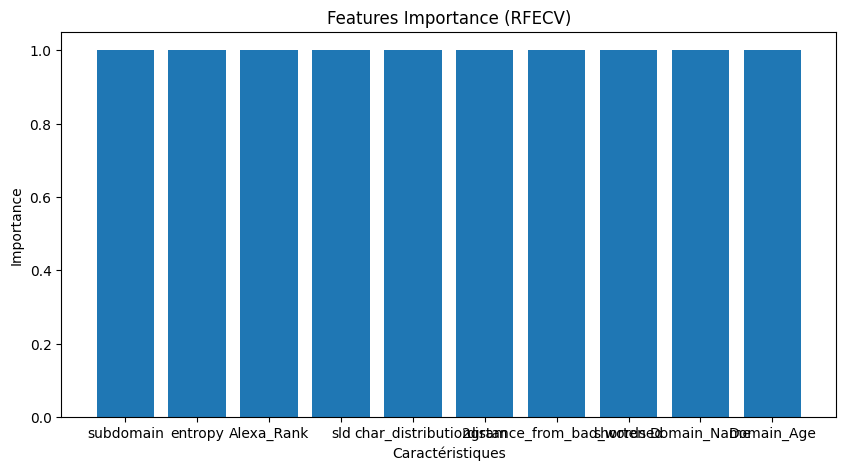

In [19]:
#### JE PLOT LES FEATURES SELECTIONNEES #########

import matplotlib.pyplot as plt
import numpy as np

# Affichage des résultats
plt.figure(figsize=(10, 5))
plt.bar(selected_columns_names, np.ones(len(selected_columns_names)))
plt.title("Features Importance (RFECV)")
plt.xlabel("Caractéristiques")
plt.ylabel("Importance")
plt.show()

In [ ]:
#################################################################
#################################################################
############ Fin Features Selection  ############################
#################################################################
#################################################################
#################################################################


In [21]:
# Séparer les caractéristiques numériques et catégorielles

# X_numerical = X.select_dtypes(include='number')
# X_categorical = X.select_dtypes(exclude='number')

#### AUTRE METHODES ##################

X_numerical = all_data[['subdomain','entropy','Alexa_Rank']]

X_categorical = all_data[['sld','char_distribution','2gram','distance_from_bad_words','shortened','Domain_Name','Domain_Age']]

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Imputer les valeurs manquantes pour les caractéristiques numériques

# Imputer les valeurs manquantes pour les caractéristiques numériques
numerical_imputer = SimpleImputer(strategy='mean')
X_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_numerical), columns=X_numerical.columns)


# Création d'un scaler
scaler = MinMaxScaler()

# Ajustement du scaler aux données
scaler.fit(X_numerical_imputed)

# Transformation des fonctionnalités numériques
scaled_numeric_features = scaler.transform(X_numerical_imputed)

# Apres transformation Création d' un DataFrame à partir des valeurs transformées

scaled_df = pd.DataFrame(scaled_numeric_features, columns=X_numerical_imputed.columns)

# Afficher le DataFrame avec les valeurs transformées
print("Après transformation")
print(scaled_df)

total_size = scaled_df.shape

print("Taille totale des caracteristiques numeriques apres concatenations :", total_size)

Après transformation
       subdomain   entropy    Alexa_Rank
0            0.0  0.384930  1.636035e-07
1            0.0  0.384930  1.636035e-07
2            1.0  0.443538  1.636035e-07
3            1.0  0.443538  1.636035e-07
4            0.0  0.544495  6.544140e-07
...          ...       ...           ...
50154        0.0  0.651767  0.000000e+00
50155        0.0  0.709024  0.000000e+00
50156        0.0  0.652033  0.000000e+00
50157        0.0  0.619471  0.000000e+00
50158        0.0  0.718409  0.000000e+00

[50159 rows x 3 columns]
Taille totale des caracteristiques numeriques apres concatenations : (50159, 3)


In [23]:
# Imputer les valeurs manquantes pour les caractéristiques catégorielles

categorical_imputer = SimpleImputer(strategy='most_frequent')
# all_data_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X.select_dtypes(exclude='number')), columns=X.select_dtypes(exclude='number').columns) ## JE TESTE LA SECONDE METHODE
all_data_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical), columns=X_categorical.columns)


In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd

# Créer une copie du DataFrame categoriciel  pour éviter SettingWithCopyWarning
X_copy = all_data_categorical_imputed.copy()

# Appliquer une tokenisation à chaque colonne catégorielle
for feature in all_data_categorical_imputed.columns.tolist():
    X_copy[feature] = X_copy[feature].astype(str)

# Combinaison des features textuelles avec un séparateur
    
# X_copy['combined_text'] = X_copy[categorical_features].apply(lambda row: ' SEPARATOR '.join(row), axis=1)
    
#Avec le separator les donnee ne sont pas bien combinée il y'a  les tokens vide et la longueur max c'est 1 d'ou c'est pas bon    
  
X_copy['combined_text'] = X_copy[all_data_categorical_imputed.columns.tolist()].apply(lambda row: ' '.join(row), axis=1)

# Tokenisation des textes combinés

# tokenizer = Tokenizer(num_words=10, filters='', split=' SEPARATOR ')

#Avec le separator les donnee ne sont pas bien combinée il y'a  les tokens vide et la longueur max c'est 1 d'ou c'est pas bon    

tokenizer = Tokenizer(num_words=10, filters=' ', split=' ')
tokenizer.fit_on_texts(X_copy['combined_text'])
tokens = tokenizer.texts_to_sequences(X_copy['combined_text'])

# Calcul de la longueur maximale du vecteur
max_sequence_length = max(len(seq) for seq in tokens)

# Ajout des colonnes tokenisées au DataFrame
for i in range(1, max_sequence_length+1):
    X_copy[f'token_{i}'] = [seq[i - 1] if len(seq) >= i else 0 for seq in tokens]

# Suppression des colonnes originales et la colonne temporaire 'combined_text'
X_copy.drop(columns=all_data_categorical_imputed.columns.tolist() + ['combined_text'], inplace=True)

# Afficher les tokens et les longueurs de séquence
print("Tokens:")
print(tokens)
print("\nLongueurs de séquence:")
print([len(seq) for seq in tokens])

#je garde les les sequences

seq_l = [len(seq) for seq in tokens]


# Calcul de la longueur maximale du vecteur
max_sequence_length = max(len(seq) for seq in tokens)

# Affichage de la longueur maximale
print(f"Longueur maximale du vecteur : {max_sequence_length}")


Tokens:
[[3, 4, 2, 2, 1, 8, 7, 5, 6], [3, 4, 2, 2, 1, 8, 7, 5, 6], [3, 4, 9, 2, 2, 1, 8, 7, 5, 6], [3, 4, 9, 2, 2, 1, 8, 7, 5, 6], [3, 4, 1, 1, 1, 8, 1, 1, 2, 7, 5, 6], [3, 4, 1, 1, 1, 8, 1, 1, 2, 7, 5, 6], [3, 4, 1, 1, 1, 8, 1, 1, 2, 7, 5, 6], [3, 4, 1, 1, 1, 8, 1, 1, 2, 7, 5, 6], [3, 4, 9, 1, 1, 1, 8, 1, 1, 2, 7, 5, 6], [3, 4, 9, 1, 1, 1, 8, 1, 1, 2, 7, 5, 6], [3, 4, 1, 1, 2, 1, 1, 8, 7, 5, 6], [3, 4, 1, 1, 2, 1, 1, 8, 7, 5, 6], [3, 4, 1, 1, 2, 1, 1, 8, 7, 5, 6], [3, 4, 1, 1, 2, 1, 1, 8, 7, 5, 6], [3, 4, 9, 1, 1, 2, 1, 1, 8, 7, 5, 6], [3, 4, 9, 1, 1, 2, 1, 1, 8, 7, 5, 6], [3, 4, 9, 1, 1, 8, 1, 7, 5, 6], [3, 4, 9, 1, 1, 8, 1, 7, 5, 6], [3, 4, 1, 2, 2, 1, 8, 1, 7, 5, 6], [3, 4, 1, 2, 2, 1, 8, 1, 7, 5, 6], [3, 4, 9, 1, 2, 2, 1, 8, 1, 7, 5, 6], [3, 4, 9, 1, 2, 2, 1, 8, 1, 7, 5, 6], [3, 4, 1, 1, 1, 1, 2, 1, 1, 7, 5, 6], [3, 4, 9, 1, 1, 1, 1, 2, 1, 1, 7, 5, 6], [3, 4, 9, 1, 1, 1, 1, 2, 1, 1, 7, 5, 6], [3, 4, 1, 1, 1, 1, 2, 1, 1, 7, 5, 6], [3, 4, 1, 1, 1, 1, 2, 1, 1, 7, 5, 6], [3, 4, 1, 1, 

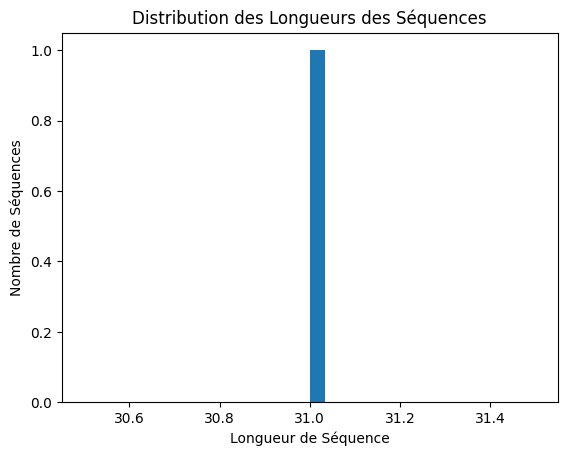

In [27]:


mean_length = np.mean(max_sequence_length)
max_length = np.max(max_sequence_length)
min_length = np.min(max_sequence_length)
std_dev = np.std(max_sequence_length)

# Visualisation de la distribution des longueurs des séquences
import matplotlib.pyplot as plt
plt.hist(max_sequence_length, bins=30)
plt.xlabel('Longueur de Séquence')
plt.ylabel('Nombre de Séquences')
plt.title('Distribution des Longueurs des Séquences')
plt.show()

In [28]:
# Hyperparamètres et dimensions des données*
taille_num_features = scaled_df.shape[1]
taille_text_features = max_sequence_length     # je donne la taille max parmi les longueur des sequences
vocab_size = 20000  
embedding_dim = 128  


In [29]:
# Entrées

input_num = tf.keras.layers.Input(shape=(taille_num_features,))
input_text = tf.keras.layers.Input(shape=(taille_text_features,))

# Branches du modèle
# Branche numérique - FFN

num_branch = tf.keras.layers.Dense(64, activation='relu')(input_num)
num_branch = tf.keras.layers.Dense(32, activation='relu')(num_branch)


# Branche textuelle - Embedding + LSTM
# Branche textuelle - Embedding + Transformer (Un block)

text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features)(input_text)

mask_inputs = masque_remplissage(input_text) 

out_seq = Encodeur(
    n_layers=4, d_model=128, num_heads=8,
    middle_units=256, max_seq_len=taille_text_features)([text_branch, mask_inputs])
out_seq = GlobalAveragePooling1D()(out_seq)
out_seq = Dropout(0.3)(out_seq)

# Fusion des branches 

# Fusion des branches 

flattened_text_branch = tf.keras.layers.Flatten()(text_branch) # je remodelise les dimension
merged = tf.keras.layers.concatenate([num_branch, flattened_text_branch])

In [30]:
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, concatenate, Dropout

# Couches supplémentaires après la fusion
merged = Dropout(0.3)(merged)
merged = Dense(16, activation='relu')(merged)
output = Dense(4, activation='softmax')(merged)  # 4 classes


In [35]:

# Création et compilation du modèle

model = Model(inputs=[input_num, input_text], outputs=output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           256         ['input_1[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 31, 128)      2560000     ['input_2[0][0]']                
                                                                                            

In [39]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler, LabelEncoder



labels = all_data['Class']

# Entrées pour l'entraînement
data_num = scaled_numeric_features    
data_text = pad_sequences(tokens, maxlen=max_length,padding='post')

print(labels)

# Encodage de la cible en labels numériques
### on a notre [Y] de depart je peut use [labels] egaelement
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(y_encoded)




0        Benin
1        Benin
2        Benin
3        Benin
4        Benin
         ...  
50154     Spam
50155     Spam
50156     Spam
50157     Spam
50158     Spam
Name: Class, Length: 50159, dtype: object
[0 0 0 ... 3 3 3]


In [40]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
text_train, text_test, num_train, num_test, labels_train, labels_test = train_test_split(
    data_text, data_num, y_encoded, test_size=0.2, random_state=42
)

In [27]:
print("Shape of text_train:", text_train.shape)
print("Shape of labels_train:", labels_train.shape)
print("Shape of text_test:", text_test.shape)
print("Shape of labels_test:", labels_test.shape)
print("Shape of num_train:", num_train.shape)
print("Shape of num_test:", num_test.shape)

print("Visualisation des dimension et du batch_size\n")

batch_size, dimension = text_train.shape[0], text_train.shape[1]
print("Batch size text train:", batch_size)
print("Dimension text train:", dimension)

batch_size, dimension = num_train.shape[0], num_train.shape[1]
print("Batch size num train:", batch_size)
print("Dimension num train:", dimension)



Shape of text_train: (40127, 31)
Shape of labels_train: (40127,)
Shape of text_test: (10032, 31)
Shape of labels_test: (10032,)
Shape of num_train: (40127, 3)
Shape of num_test: (10032, 3)
Visualisation des dimension et du batch_size

Batch size text train: 40127
Dimension text train: 31
Batch size num train: 40127
Dimension num train: 3


In [ ]:
# Afficher quelques exemples des données d'entraînement
print("Exemples des données d'entraînement:")
print("Text_train:")
print(text_train[:5])
print("\nNum_train:")
print(num_train[:5])
print("\nLabels_train:")
print(labels_train[:5])

# Faire de même pour les données de test


# Vérifier si des valeurs nan sont présentes
print("\nVérification des valeurs nan:")
print("Text_train contains nan:", np.isnan(text_train).any())
print("Num_train contains nan:", np.isnan(num_train).any())
print("Labels_train contains nan:", np.isnan(labels_train).any())

# Faire de même pour les données de test



In [ ]:
##############Verification de nouveau


# Afficher quelques exemples des données d'entraînement
print("Exemples des données d'entraînement:")
print("Text_train:")
print(text_train[:5])
print("\nNum_train:")
print(num_train[:5])
print("\nLabels_train:")
print(labels_train[:5])

# Faire de même pour les données de test


# Vérifier si des valeurs nan sont présentes
print("\nVérification des valeurs nan:")
print("Text_train contains nan:", np.isnan(text_train).any())
print("Num_train contains nan:", np.isnan(num_train).any())
print("Labels_train contains nan:", np.isnan(labels_train).any())

# Faire de même pour les données de test



In [41]:
### A ne pas executer  car j'execute cela lors de la recherche des HytperParametre

history = model.fit([num_train,text_train], labels_train, epochs=60, batch_size=32, validation_data=([num_test,text_test], labels_test))


Train on 40127 samples, validate on 10032 samples
Epoch 1/60
40127/40127 [==============================] - ETA: 0s - loss: 0.6643 - accuracy: 0.7278

c:\python install\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


40127/40127 [==============================] - 194s 5ms/sample - loss: 0.6643 - accuracy: 0.7278 - val_loss: 0.5317 - val_accuracy: 0.7756
Epoch 2/60
40127/40127 [==============================] - 203s 5ms/sample - loss: 0.5216 - accuracy: 0.7838 - val_loss: 0.4886 - val_accuracy: 0.7955
Epoch 3/60
40127/40127 [==============================] - 195s 5ms/sample - loss: 0.4910 - accuracy: 0.7965 - val_loss: 0.4743 - val_accuracy: 0.8020
Epoch 4/60
40127/40127 [==============================] - 204s 5ms/sample - loss: 0.4742 - accuracy: 0.8031 - val_loss: 0.4574 - val_accuracy: 0.8088
Epoch 5/60
40127/40127 [==============================] - 285s 7ms/sample - loss: 0.4556 - accuracy: 0.8120 - val_loss: 0.4584 - val_accuracy: 0.8113
Epoch 6/60
40127/40127 [==============================] - 272s 7ms/sample - loss: 0.4409 - accuracy: 0.8154 - val_loss: 0.4418 - val_accuracy: 0.8125
Epoch 7/60
40127/40127 [==============================] - 288s 7ms/sample - loss: 0.4328 - accuracy: 0.8192 - v

In [42]:
#on effectue les prediction sur les donnees de test

y_pred = model.predict([num_test,text_test])

print(y_pred)

y_pred_classes = np.argmax(y_pred, axis=1)

c:\python install\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[9.9977928e-01 1.8545991e-04 3.5254892e-05 1.4896977e-19]
 [9.7392895e-04 7.9416239e-01 2.0486367e-01 5.6599038e-16]
 [1.4184228e-01 3.7827149e-01 4.7988591e-01 3.0909416e-07]
 ...
 [9.8918599e-01 1.1614348e-03 9.6525736e-03 1.4128448e-14]
 [1.8542601e-01 4.1774601e-01 3.9682794e-01 3.0275068e-08]
 [9.9904925e-01 1.2126842e-04 8.2955504e-04 6.5443961e-19]]


In [43]:
from sklearn.metrics import classification_report

# Convertir les indices des classes prédites en étiquettes
y_pred_classes = np.argmax(y_pred, axis=1)

# Afficher le rapport de classification
class_report = classification_report(labels_test, y_pred_classes)
print("Rapport de classification :\n", class_report)


Rapport de classification :
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      4843
           1       0.67      0.75      0.71      1877
           2       0.81      0.81      0.81      2465
           3       1.00      1.00      1.00       847

    accuracy                           0.85     10032
   macro avg       0.85      0.86      0.86     10032
weighted avg       0.86      0.85      0.85     10032



In [44]:
# Évaluation du modèle sur les données de test
evaluation_results = model.evaluate([num_test, text_test], labels_test)
# loss, accuracy = model.evaluate([num_test, text_test], labels_test)


# Affichage des résultats

# print(f'Accuracy: {accuracy}, Loss: {loss}')
print("Perte sur les données de test:", evaluation_results[0])
print("Précision sur les données de test:", evaluation_results[1])


Perte sur les données de test: 0.3560214294581132
Précision sur les données de test: 0.85217303


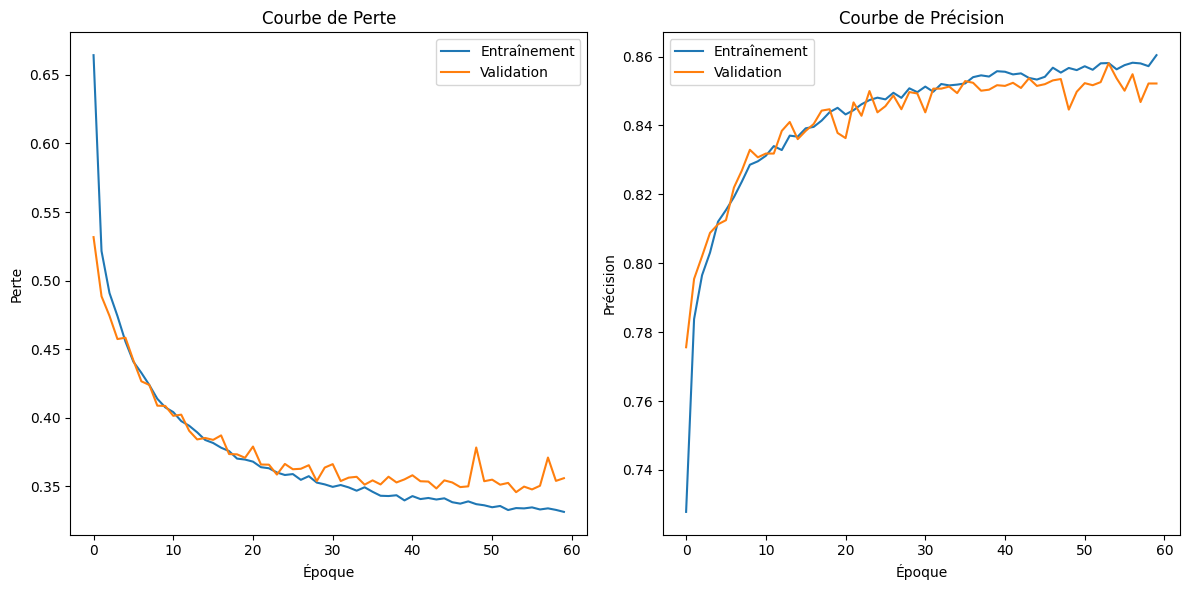

In [46]:
# Affichage des courbes d'apprentissage et de validation
plt.figure(figsize=(12, 6))

# Plot de la perte d'entraînement et de la perte de validation
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Courbe de Perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()


# Plot de la précision d'entraînement et de la précision de validation
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Courbe de Précision')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()

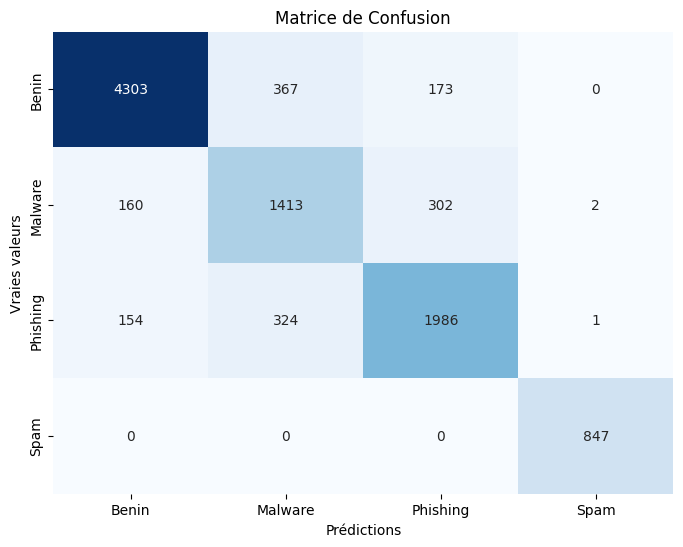

In [47]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, roc_curve, auc



# Matrice de confusion
conf_matrix = confusion_matrix(labels_test, y_pred_classes)
class_names = ['Benin', 'Malware', 'Phishing', 'Spam']
df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()

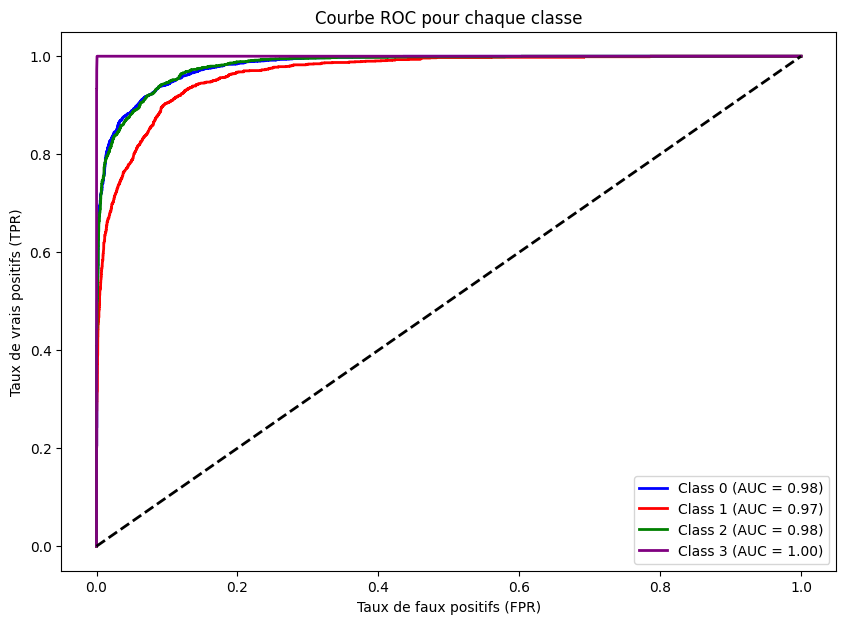

In [76]:
from tensorflow.keras.utils import to_categorical


# Courbe ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

y_test_one_hot = to_categorical(labels_test, num_classes=4)

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotter la courbe ROC pour chaque classe
plt.figure(figsize=(10, 7))
colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC pour chaque classe')
plt.legend(loc='lower right')
plt.show()

In [ ]:
############################################ Marche tres bien ############
################################## En utilisant le BayesianOptimization() et le ModelChekpoint qui detient le meilleur model ] #######################


##### Hyper parametre Tuning
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.metrics import AUC


from tensorflow.keras.callbacks import ModelCheckpoint
from kerastuner.tuners import BayesianOptimization




# Définir la fonction pour la recherche des hyperparamètres
def build_model(hp):
    model = Model(inputs=[input_num, input_text], outputs=output)

    # Définir les hyperparamètres à optimiser
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    hp_lstm_units = hp.Choice('lstm_units', values=[64, 128, 256])
    hp_dense_units = hp.Choice('dense_units', values=[16, 32, 64])
    hp_embedding_dim = hp.Choice('embedding_dim', values=[64, 128, 256])

    # Compiler le modèle avec les hyperparamètres
    # optimizer = Adam(lr=hp_learning_rate)

    optimizer = Adam(learning_rate=hp_learning_rate)

    # model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', AUC()])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    return model

# Diviser les données en ensembles d'entraînement et de test
text_train, text_test, num_train, num_test, labels_train, labels_test = train_test_split(
    data_text, data_num, y_encoded, test_size=0.2, random_state=42
)

#Pour resoudre les erreur 
import os

# Vérifier si le répertoire existe, sinon le créer
save_directory = 'my_dir'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Créer un tuner pour la recherche des hyperparamètres

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    hyperparameters=HyperParameters(),
    directory=save_directory,
    project_name='lstm_ffn_hyperparam_tuning'
)

# Définir un callback ModelCheckpoint pour sauvegarder le meilleur modèle
filepath=os.path.abspath('my_dir/lstm_ffn_hyperparam_tuning/best_model.h5')

checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


# Rechercher les meilleurs hyperparamètres en utilisant les données d'entraînement et de validation
# Utiliser le callback BayesianOptimizationCallback

tuner.search([num_train, text_train], labels_train, epochs=5, validation_data=([num_test, text_test], labels_test), callbacks=[checkpoint_callback])

# Obtenir les meilleurs hyperparamètres trouvés
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Best hyperparameters: {best_hps}")

# Réutiliser les meilleurs hyperparamètres pour construire le modèle final
model = build_model(best_hps)

# Entraîner le modèle avec les données complètes
model.fit([num_train, text_train], labels_train, epochs=5, batch_size=32, validation_data=([num_test, text_test], labels_test))


#######################################################################################################


############################################ Marche tres bien ############
################################## En utilisant le BayesianOptimization() et le ModelChekpoint qui detient le meilleur model ] #######################


# Définir la fonction pour la recherche des hyperparamètres
def build_model(hp):
    model = Model(inputs=[input_num, input_text], outputs=output)

    # Définir les hyperparamètres à optimiser
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    hp_lstm_units = hp.Choice('lstm_units', values=[64, 128, 256])
    hp_dense_units = hp.Choice('dense_units', values=[16, 32, 64])
    hp_embedding_dim = hp.Choice('embedding_dim', values=[64, 128, 256])

    # Compiler le modèle avec les hyperparamètres
    # optimizer = Adam(lr=hp_learning_rate)
    optimizer = Adam(learning_rate=hp_learning_rate)

    # model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', AUC()])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    return model

# Diviser les données en ensembles d'entraînement et de test
text_train, text_test, num_train, num_test, labels_train, labels_test = train_test_split(
    data_text, data_num, y_encoded, test_size=0.2, random_state=42
)

#Pour resoudre les erreur 
import os

# Vérifier si le répertoire existe, sinon le créer
save_directory = 'my_dir'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Créer un tuner pour la recherche des hyperparamètres

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    hyperparameters=HyperParameters(),
    directory=save_directory,
    project_name='lstm_ffn_hyperparam_tuning'
)

# Définir un callback ModelCheckpoint pour sauvegarder le meilleur modèle
filepath=os.path.abspath('my_dir/lstm_ffn_hyperparam_tuning/best_model.h5')

checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


# Rechercher les meilleurs hyperparamètres en utilisant les données d'entraînement et de validation
# Utiliser le callback BayesianOptimizationCallback

tuner.search([num_train, text_train], labels_train, epochs=5, validation_data=([num_test, text_test], labels_test), callbacks=[checkpoint_callback])

# Obtenir les meilleurs hyperparamètres trouvés
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Best hyperparameters: {best_hps}")

# Réutiliser les meilleurs hyperparamètres pour construire le modèle final
model = build_model(best_hps)

# Entraîner le modèle avec les données complètes
history = model.fit([num_train, text_train], labels_train, epochs=5, batch_size=32, validation_data=([num_test, text_test], labels_test))
